In [1]:
#install python (and check the add to path option during installation), then install the ema_workbench python module.
#this can be done by executing the following command in the command prompt:
# pip install ema_workbench

#import necessary python libraries for the analysis
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

#import EMA workbench tools
from ema_workbench.em_framework import samplers, evaluators, util
from ema_workbench import (RealParameter, ScalarOutcome, Model, Constant)
from ema_workbench import (perform_experiments, ema_logging, save_results, 
                           load_results, SequentialEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)


#import PRIM algorithm
from ema_workbench.analysis import prim

C:\Users\Timme\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Timme\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# 1. Load the data for the global and local analysis

In [2]:
raw_data = pd.read_csv("Data/Costs and benefits of photovoltaic-green roofs.csv")
raw_data

,Technology,Green roof type,Plant species,Irrigation,PV panel type,PV panels and GR locations,Distance PV-green roof [cm],Distance PV-basecase roof [cm],Season,Base case roof situation,...,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76
0,Photovoltaic-green roof,Extensive,NaN,not mentioned,NaN,Same location,NaN,NaN,annual average,To be constructed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Photovoltaic-green roof,Extensive,NaN,not mentioned,NaN,Same location,NaN,NaN,annual average,To be constructed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Photovoltaic-green roof,Extensive,NaN,not mentioned,NaN,Same location,NaN,NaN,annual average,To be constructed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Photovoltaic-green roof,Extensive,NaN,not mentioned,NaN,Same location,NaN,NaN,annual average,To be constructed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Photovoltaic-green roof,Extensive,NaN,not mentioned,NaN,Same location,NaN,NaN,annual average,To be constructed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
raw_data.columns

Index(['Technology', 'Green roof type', 'Plant species', 'Irrigation',
       'PV panel type', 'PV panels and GR locations',
       'Distance PV-green roof [cm]', 'Distance PV-basecase roof [cm]',
       'Season', 'Base case roof situation', 'Building type', 'Base case roof',
       'Base case insulation', 'Roof slope', 'Item', 'Item type', 'Item scale',
       'Item class', 'Original monetary value', 'u.m.',
       'Original year(s) at which the item is accounted',
       'Green roof lifetime [years]',
       'Actual year(s) at which the item is accounted',
       'Actual monetary value at the accounting year',
       'Inflation adjustment ratio [GDP deflator 2020/GDP deflator year]',
       'PPP Exchange rate [€ EU27-2020/ local currency-2020]',
       'Adjusted Monetary value [EU27 2020 €/m2]', 'Method for monetary value',
       'Quantiative absolute evaluation', 'u.m.3',
       'Method for absolute evaluation', 'Quantiative absolute evaluation 2',
       'u.m. 3', 'Method for abso

In [4]:
raw_data.Item.unique()

array(['Urban heat island effect mitigation',
       'Air quality enhancement and CO2 reduction',
       'Flood risk reduction',
       'Stormwater management (without flood risk reduction)',
       'Water runoff quality increase', 'Urban noise reduction',
       'Biodiversity enhancement',
       'Energy consumption reduction (cooling)',
       'Energy consumption reduction (heating)',
       'Energy consumption reduction (heating and cooling)',
       'Sound insulation', 'Aesthetics increase',
       'Replacement of vegetation cover', 'Replacement of drainage layer',
       'Replacement and disposal of green roof',
       'Photovoltaic performance increase',
       'Installation of green roof (net)',
       'Maintenance of green roof (without drainage and vegetation layer replacements)',
       'Longevity increase', 'Fire risk reduction',
       'Maintenance of green roof (net)', 'Incentive',
       'Air quality enhancement', 'CO2 emission reduction',
       'Stormwater management', 

In [5]:
# Selection of global analysis' data

# Only aggregated versions of benefits (e.g., energy consumption total, instead of energy consumption cooling only) are kept
# and differential values with respect of the construction of the alternative basecase roof (i.e., net values) are kept. 
# This choice is due to the fact that net values are more numerous than gross values.

global_items = raw_data[((raw_data["Technology"] == "Green roof") | 
                         (raw_data["Technology"] == "Photovoltaic-green roof") ) &
                        (raw_data["Unusable monetary value"] != "x") &
                        ((raw_data["Item"] == "Urban heat island effect mitigation") |
                        (raw_data["Item"] == "Water runoff quality increase") |
                        (raw_data["Item"] == "Urban noise reduction") |
                        (raw_data["Item"] == "Biodiversity enhancement") |
                        (raw_data["Item"] == "Energy consumption reduction (heating and cooling)") |
                        (raw_data["Item"] == "Sound insulation") |
                        (raw_data["Item"] == "Aesthetics increase") |
                        (raw_data["Item"] == "Replacement and disposal of green roof") |
                        (raw_data["Item"] == "Installation of green roof (net)") |
                        (raw_data["Item"] == "Longevity increase") |
                        (raw_data["Item"] == "Fire risk reduction") |
                        (raw_data["Item"] == "Maintenance of green roof (net)") |
                        (raw_data["Item"] == "Air quality enhancement") |
                        (raw_data["Item"] == "CO2 emission reduction") |
                        (raw_data["Item"] == "Stormwater management") |
                        (raw_data["Item"] == "Air pollution from green roof production") |
                        (raw_data["Item"] == "CO2 emissions from green roof production") |
                        (raw_data["Item"] == "CO2 uptake") |
                        (raw_data["Item"] == "Electricity generation") |
                        (raw_data["Item"] == "Water runoff quality increase") |
                        (raw_data["Item"] == "Local area's aesthetics increase") |
                        (raw_data["Item"] == "Installation of PV panels"))]

global_items = global_items[["Item","Item type", "Actual year(s) at which the item is accounted", "Adjusted Monetary value [EU27 2020 €/m2]"]]

global_costs = global_items[ (global_items["Item type"]=="cost") ]
global_benefits = global_items[ (global_items["Item type"]=="benefit") ]
display(global_costs)
display(global_benefits)

,Item,Item type,Actual year(s) at which the item is accounted,Adjusted Monetary value [EU27 2020 €/m2]
77,Replacement and disposal of green roof,cost,last year,19.779366
82,Replacement and disposal of green roof,cost,last year,19.766926
87,Installation of green roof (net),cost,0,51.612949
89,Replacement and disposal of green roof,cost,last year,30.141763
92,Replacement and disposal of green roof,cost,last year,19.941084
...,...,...,...,...
775,Maintenance of green roof (net),cost,every year,3.184810
776,Maintenance of green roof (net),cost,every year,4.028232
777,Maintenance of green roof (net),cost,every year,3.184810
778,Maintenance of green roof (net),cost,every year,3.523174


,Item,Item type,Actual year(s) at which the item is accounted,Adjusted Monetary value [EU27 2020 €/m2]
0,Urban heat island effect mitigation,benefit,every year,0.124399
1,Urban heat island effect mitigation,benefit,every year,0.124399
2,Urban heat island effect mitigation,benefit,every year,0.124399
3,Urban heat island effect mitigation,benefit,every year,0.124399
4,Urban heat island effect mitigation,benefit,every year,0.124399
...,...,...,...,...
809,Stormwater management,benefit,every year,0.049980
810,Stormwater management,benefit,every year,0.044064
814,Stormwater management,benefit,every year,0.026724
815,Stormwater management,benefit,every year,0.033762


In [6]:
# Selection of local analysis' data

local_items = raw_data[((raw_data["Technology"] == "Green roof") | 
                         (raw_data["Technology"] == "Photovoltaic-green roof") ) &
                        (raw_data["Base case roof"] == "black roof") &
                        (raw_data["Climate"] == "Cfb") &
                        (raw_data["Continent"] == "Europe") &
                        (raw_data["Unusable monetary value"] != "x") &
                        ((raw_data["Item"] == "Urban heat island effect mitigation") |
                        (raw_data["Item"] == "Water runoff quality increase") |
                        (raw_data["Item"] == "Urban noise reduction") |
                        (raw_data["Item"] == "Biodiversity enhancement") |
                        (raw_data["Item"] == "Energy consumption reduction (heating and cooling)") |
                        (raw_data["Item"] == "Sound insulation") |
                        (raw_data["Item"] == "Aesthetics increase") |
                        (raw_data["Item"] == "Replacement and disposal of green roof") |
                        (raw_data["Item"] == "Installation of green roof (net)") |
                        (raw_data["Item"] == "Longevity increase") |
                        (raw_data["Item"] == "Fire risk reduction") |
                        (raw_data["Item"] == "Maintenance of green roof (net)") |
                        (raw_data["Item"] == "Air quality enhancement") |
                        (raw_data["Item"] == "CO2 emission reduction") |
                        (raw_data["Item"] == "Stormwater management") |
                        (raw_data["Item"] == "Air pollution from green roof production") |
                        (raw_data["Item"] == "CO2 emissions from green roof production") |
                        (raw_data["Item"] == "CO2 uptake") |
                        (raw_data["Item"] == "Electricity generation") |
                        (raw_data["Item"] == "Water runoff quality increase") |
                        (raw_data["Item"] == "Local area's aesthetics increase") |
                        (raw_data["Item"] == "Installation of PV panels"))]

local_items = local_items[["Item","Item type", "Actual year(s) at which the item is accounted", "Adjusted Monetary value [EU27 2020 €/m2]"]]

local_costs = local_items[ (local_items["Item type"]=="cost") ]
local_benefits = local_items[ (local_items["Item type"]=="benefit") ]
display(local_costs)
display(local_benefits)

,Item,Item type,Actual year(s) at which the item is accounted,Adjusted Monetary value [EU27 2020 €/m2]
159,Installation of green roof (net),cost,0,33.212560
160,Maintenance of green roof (net),cost,every year,1.082310
161,Installation of green roof (net),cost,0,34.841625
162,Installation of green roof (net),cost,0,31.583495
163,Maintenance of green roof (net),cost,every year,1.079255
164,Maintenance of green roof (net),cost,every year,1.085364
322,Installation of green roof (net),cost,0,74.175124
323,Installation of green roof (net),cost,0,92.718905
324,Installation of green roof (net),cost,0,69.539179
325,Installation of green roof (net),cost,0,74.175124


,Item,Item type,Actual year(s) at which the item is accounted,Adjusted Monetary value [EU27 2020 €/m2]
172,Sound insulation,benefit,every year,0.292214
173,Sound insulation,benefit,every year,0.277959
174,Sound insulation,benefit,every year,0.306468
175,Longevity increase,benefit,every year,7.343010
176,Longevity increase,benefit,every year,7.343010
177,Longevity increase,benefit,every year,7.343010
178,Air quality enhancement,benefit,every year,0.375703
179,Air quality enhancement,benefit,every year,0.012625
180,Air quality enhancement,benefit,every year,0.499919
181,Urban heat island effect mitigation,benefit,every year,0.000000


In [7]:
# Visualize the years at which the costs and benefits need to be accounted in the CBA Model

global_costs.groupby("Item")["Actual year(s) at which the item is accounted"].agg(lambda x:x.value_counts().index[0])

global_benefits.groupby("Item")["Actual year(s) at which the item is accounted"].agg(lambda x:x.value_counts().index[0])

Item
Aesthetics increase                                            0
Air quality enhancement                               every year
Biodiversity enhancement                              every year
CO2 emission reduction                                every year
CO2 uptake                                            every year
Electricity generation                                every year
Energy consumption reduction (heating and cooling)    every year
Fire risk reduction                                   every year
Local area's aesthetics increase                               0
Longevity increase                                    every year
Sound insulation                                      every year
Stormwater management                                 every year
Urban heat island effect mitigation                   every year
Urban noise reduction                                 every year
Water runoff quality increase                         every year
Name: Actual year(s)

## 1.1 Number of items for the global analysis

In [8]:
# determining the amount of datapoints within the range, so to gain insight into the representativeness of the using the range (i.e., max-min) for each 
# cost or benefit

def q1(Item):
    return Item.quantile(0.25)

def q3(Item):
    return Item.quantile(0.75)

def lower_whisker(Item):
     return max([Item.min(), q1(Item)-1.5*(q3(Item)-q1(Item)) ])


def upper_whisker(Item):
    return q3(Item)+1.5*(q3(Item)-q1(Item))
#     whisker_lim = q3(Item)+1.5*(q3(Item)-q1(Item))
#     upper_whisker = Item["Adjusted Monetary value [EU27 2020 €/m2]"].max()
#     values_df = Item.sort_values(by='Adjusted Monetary value [EU27 2020 €/m2]',ascending=True)
#     i = 1
    
#     while upper_whisker > whisker_lim:
#         upper_whisker = values_df.iloc[-(1+i)]
#         i +=1

#     return upper_whisker



def density(Item):
    if Item.max() - Item.min() == 0:
        return "one value only"
    return Item.nunique()/ ( Item.max() - Item.min() )

def spacing(Item):
    return ( Item.max() - Item.min() ) / Item.nunique()

def n_without_outliers(Item):
    """This function calculates the number of unique values recorded for each item (i.e., cost or benefit), which are not
    outliers"""
    values_to_count = []
    
    for number in Item:
        if ((number >= lower_whisker(Item)) & (number <= upper_whisker(Item))):
            values_to_count.append(number)
    #only unique values are counted, so the length of the set associated to the list, instead of the list is returned
    return len(set(values_to_count))
def average(Item):
    return Item.mean()

def density_without_outliers(Item):
    return n_without_outliers(Item) / ( upper_whisker(Item) - lower_whisker(Item) )

def spacing_without_outliers(Item):
    return ( upper_whisker(Item) - lower_whisker(Item) ) / n_without_outliers(Item)

def n_outliers(Item):
    values_to_count = []
    for number in Item:
        if (( number < lower_whisker(Item) ) | ( number > upper_whisker(Item) )):
            values_to_count.append(number)
            
    #only unique values are counted, so the length of the set associated to the list, instead of the list is returned
    return len(set(values_to_count))


f = {'Adjusted Monetary value [EU27 2020 €/m2]': ['nunique', average, 'min', q1, 'median', q3, 'max',spacing, n_without_outliers, spacing_without_outliers]}
gl_summary_costs = global_costs.groupby('Item').agg(f)

# drop one level of the Multi-level data structure, so to have 2D Pandas DataFrame
gl_summary_costs.columns = gl_summary_costs.columns.droplevel()

# Replace the spaces in the row indexes' names (i.e., the benefits' names) with an underscore, and delete parentheses,
# so to be able to use the benefit names as variables in the CBA Model
gl_summary_costs.index = gl_summary_costs.index.str.replace("(", "")
gl_summary_costs.index = gl_summary_costs.index.str.replace(")", "")
gl_summary_costs.index = gl_summary_costs.index.str.replace(" net", "")
gl_summary_costs.index = gl_summary_costs.index.str.replace(" ","_")

display(gl_summary_costs)

# do it again for benefits
gl_summary_benefits = global_benefits.groupby('Item').agg(f)

gl_summary_benefits.columns = gl_summary_benefits.columns.droplevel()
gl_summary_benefits.index = gl_summary_benefits.index.str.replace("(", "")
gl_summary_benefits.index = gl_summary_benefits.index.str.replace(")", "")
gl_summary_benefits.index = gl_summary_benefits.index.str.replace(" heating and cooling", "")
gl_summary_benefits.index = gl_summary_benefits.index.str.replace(" ","_")

display(gl_summary_benefits)

,nunique,average,min,q1,median,q3,max,spacing,n_without_outliers,spacing_without_outliers
Item,,,,,,,,,,
Air_pollution_from_green_roof_production,4,4.926380,0.000000,0.000000,0.000000,9.625077,15.689871,3.922468,4.0,6.015673
CO2_emissions_from_green_roof_production,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
Installation_of_PV_panels,1,407.841419,407.841419,407.841419,407.841419,407.841419,407.841419,0.000000,1.0,0.000000
Installation_of_green_roof,32,61.376191,5.227100,35.255851,62.299177,86.060229,116.815898,3.487150,32.0,4.907491
Maintenance_of_green_roof,47,1.244133,-0.893647,0.228506,0.920212,2.316177,4.028232,0.104721,47.0,0.134922
Replacement_and_disposal_of_green_roof,7,36.755779,19.766926,19.779366,25.041423,45.149490,103.855845,12.012703,6.0,10.572958


,nunique,average,min,q1,median,q3,max,spacing,n_without_outliers,spacing_without_outliers
Item,,,,,,,,,,
Aesthetics_increase,19,91.539244,1.973705,39.906160,75.544018,135.475059,328.339910,17.177169,18.0,15.380817
Air_quality_enhancement,20,0.375100,0.000000,0.068790,0.132600,0.499919,1.481821,0.074091,17.0,0.067448
Biodiversity_enhancement,9,0.280780,0.000000,0.003468,0.140782,0.671752,0.671752,0.074639,9.0,0.186020
CO2_emission_reduction,16,0.411049,-0.028056,0.016522,0.127812,0.243155,3.399472,0.214221,13.0,0.047012
CO2_uptake,9,0.447684,0.000000,0.000000,0.001230,0.024550,5.687937,0.631993,7.0,0.008768
Electricity_generation,18,11.522450,2.797891,9.915276,10.688906,15.329948,18.846151,0.891570,18.0,1.147448
Energy_consumption_reduction,67,3.492932,-0.384476,0.288924,0.807699,1.787248,54.027255,0.812115,60.0,0.073654
Fire_risk_reduction,5,0.063330,0.000000,0.031100,0.074639,0.099519,0.111959,0.022392,5.0,0.040430
Local_area's_aesthetics_increase,3,355.990747,0.000097,125.143246,250.286396,533.986072,817.685748,272.561884,3.0,382.416738


## 1.2 Number of items for the local analysis

In [9]:
f = {'Adjusted Monetary value [EU27 2020 €/m2]': ['nunique', average, 'min', lower_whisker, q1, 'median', q3, upper_whisker, 'max', density, spacing, n_without_outliers, spacing_without_outliers]}
loc_summary_costs = local_costs.groupby('Item').agg(f)

# drop one level of the Multi-level data structure, so to have 2D Pandas DataFrame
loc_summary_costs.columns = loc_summary_costs.columns.droplevel()

# Replace the spaces in the row indexes' names (i.e., the benefits' names) with an underscore, and delete parentheses,
# so to be able to use the benefit names as variables in the CBA Model
loc_summary_costs.index = loc_summary_costs.index.str.replace("(", "")
loc_summary_costs.index = loc_summary_costs.index.str.replace(")", "")
loc_summary_costs.index = loc_summary_costs.index.str.replace(" net", "")
loc_summary_costs.index = loc_summary_costs.index.str.replace(" ","_")

display(loc_summary_costs)

# do it again for benefits
loc_summary_benefits = local_benefits.groupby('Item').agg(f)

loc_summary_benefits.columns = loc_summary_benefits.columns.droplevel()
loc_summary_benefits.index = loc_summary_benefits.index.str.replace("(", "")
loc_summary_benefits.index = loc_summary_benefits.index.str.replace(")", "")
loc_summary_benefits.index = loc_summary_benefits.index.str.replace(" heating and cooling", "")
loc_summary_benefits.index = loc_summary_benefits.index.str.replace(" ","_")

display(loc_summary_benefits)

,nunique,average,min,lower_whisker,q1,median,q3,upper_whisker,max,density,spacing,n_without_outliers,spacing_without_outliers
Item,,,,,,,,,,,,,
Installation_of_green_roof,10,64.046289,18.60599,18.60599,43.516013,72.851865,76.825273,126.789162,97.135820,0.127340,7.852983,10.0,10.818317
Maintenance_of_green_roof,13,0.526630,0.03251,0.03251,0.286808,0.406867,0.878754,1.766673,1.085364,12.347385,0.080989,13.0,0.133397


,nunique,average,min,lower_whisker,q1,median,q3,upper_whisker,max,density,spacing,n_without_outliers,spacing_without_outliers
Item,,,,,,,,,,,,,
Aesthetics_increase,1,328.339910,328.339910,328.339910,328.339910,328.339910,328.339910,328.339910,328.339910,one value only,0.000000,1.0,0.000000
Air_quality_enhancement,4,0.229775,0.012625,0.012625,0.026296,0.203278,0.406757,0.977449,0.499919,8.2086,0.121824,4.0,0.241206
Biodiversity_enhancement,1,0.154169,0.154169,0.154169,0.154169,0.154169,0.154169,0.154169,0.154169,one value only,0.000000,1.0,0.000000
CO2_emission_reduction,3,0.044460,0.020363,0.020363,0.025454,0.030545,0.056508,0.103089,0.082471,48.3029,0.020703,3.0,0.027575
CO2_uptake,2,0.003129,0.002848,0.002848,0.002988,0.003129,0.003269,0.003691,0.003410,3558.42,0.000281,2.0,0.000422
Energy_consumption_reduction,12,0.572547,0.078990,0.078990,0.288924,0.392090,0.461297,0.719856,2.224229,5.59378,0.178770,10.0,0.064087
Fire_risk_reduction,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,one value only,0.000000,1.0,0.000000
Longevity_increase,3,5.045230,0.889976,0.889976,2.307143,7.343010,7.343010,14.896811,7.343010,0.464898,2.151011,3.0,4.668945
Sound_insulation,4,0.377932,0.277959,0.277959,0.288650,0.299341,0.388623,0.538582,0.635087,11.2005,0.089282,3.0,0.086874


# 2. Visualization of Costs

global boxplots' whiskers:  [array([0., 0.]), array([ 9.62507652, 15.68987092]), array([0., 0.]), array([0., 0.]), array([50.54960327, 18.60599023]), array([ 86.06022907, 116.81589831]), array([19.77936574, 19.76692589]), array([45.14949014, 58.65354226])]
local boxplots' whiskers:  [array([43.51601323, 18.60599023]), array([76.82527269, 97.13581957])]


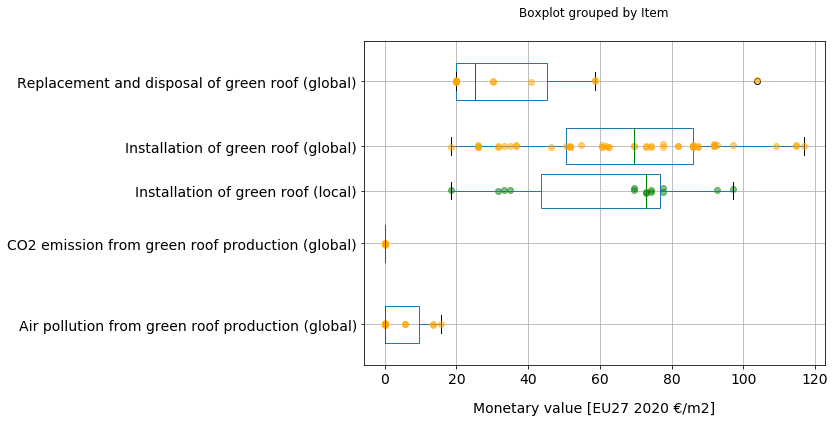

In [201]:
# plot all one-off costs (occurring one time only)

gl_costs_fig = global_costs[(global_costs["Item"]!="Installation of PV panels") &
                            (global_costs["Item"]!="Maintenance of green roof (net)")].drop([332,333,334,335,336], axis=0)

# gl_costs_fig = gl_costs_fig[(gl_costs_fig["Item"]=="Installation of green roof (net)") &
#                             (gl_costs_fig["Adjusted Monetary value [EU27 2020 €/m2]"]>7)]

loc_costs_fig = local_costs[(local_costs["Item"]!="Installation of PV panels") &
                            (local_costs["Item"]!="Maintenance of green roof (net)")]

# Add global analysis' boxplot
box_gl = gl_costs_fig.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                      figsize=(8,6), 
                      fontsize=14, 
                      showfliers=True,
                      rot=0,
                      vert=False,
                      positions = [1,2,3.2,4],
                      return_type= "both",
                      color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_costs_fig["Item"].unique()) ):
    x = gl_costs_fig["Adjusted Monetary value [EU27 2020 €/m2]"][gl_costs_fig["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    if n == 2: #in the case of the "installation of green roofs (global)" increase the height
        n = 2.2
    
    y = np.random.normal(n+1, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)
    

# Add local analysis' boxplot and datapoints
for n,item in enumerate( np.sort(loc_costs_fig["Item"].unique()) ):  #There is only the installation of green roof item
    x = loc_costs_fig["Adjusted Monetary value [EU27 2020 €/m2]"][loc_costs_fig["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(2.65, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    box_loc = plt.boxplot(x, positions = [2.65], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.42,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
plt.yticks([1, 2, 2.65, 3.2, 4], ['Air pollution from green roof production (global)',
                                 'CO2 emission from green roof production (global)',
                                 'Installation of green roof (local)',
                                 'Installation of green roof (global)',
                                 'Replacement and disposal of green roof (global)'])
plt.xlabel('Monetary value [EU27 2020 €/m2]', fontsize=14, labelpad=15)
plt.title('', fontsize=15)
plt.ylim(0.5,4.5);

plt.savefig("Figures/One-off costs",dpi=300, bbox_inches = "tight")

# Whiskers' values
print("global boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_gl[0].lines["whiskers"]])
print("local boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_loc["whiskers"]])

[array([0.28680797, 0.03250996]),
 array([0.87875407, 1.08536447]),
 array([ 0.22850602, -0.89364729]),
 array([2.31617673, 4.02823162])]

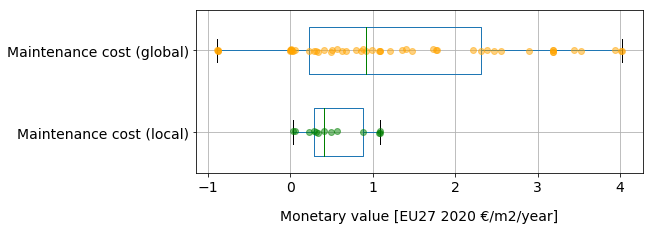

In [18]:
# plot maintenance cost (which is a yearly cost)

gl_maintenance = global_costs[global_costs["Item"]=="Maintenance of green roof (net)"]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_maintenance = local_costs[local_costs["Item"]=="Maintenance of green roof (net)"]["Adjusted Monetary value [EU27 2020 €/m2]"]

maintenance_df = pd.DataFrame({'Maintenance cost (local)': loc_maintenance, 'Maintenance cost (global)': gl_maintenance})

_, box = maintenance_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               return_type = "both",
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_maintenance))
y_local = np.random.normal(1, 0.01, size=len(loc_maintenance))

#plot the datapoints
plt.plot(gl_maintenance, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_maintenance, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

    
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Maintenance cost",dpi=300, bbox_inches = "tight")

# whiskers' values
[whiskers.get_xdata() for whiskers in box["whiskers"]]

# 3. Visualization of Benefits

## 3.1 Comparison between air quality enhancement, CO2 emission reduction, and CO2 uptake

global boxplots' whiskers:  [array([0.06879006, 0.        ]), array([0.49991928, 1.08465183]), array([ 0.01652151, -0.02805637]), array([0.24315519, 0.37512404]), array([0., 0.]), array([0.02455038, 0.03952631])]
local boxplots' whiskers:  [array([0.00298844, 0.00284792]), array([0.00326946, 0.00340997])]


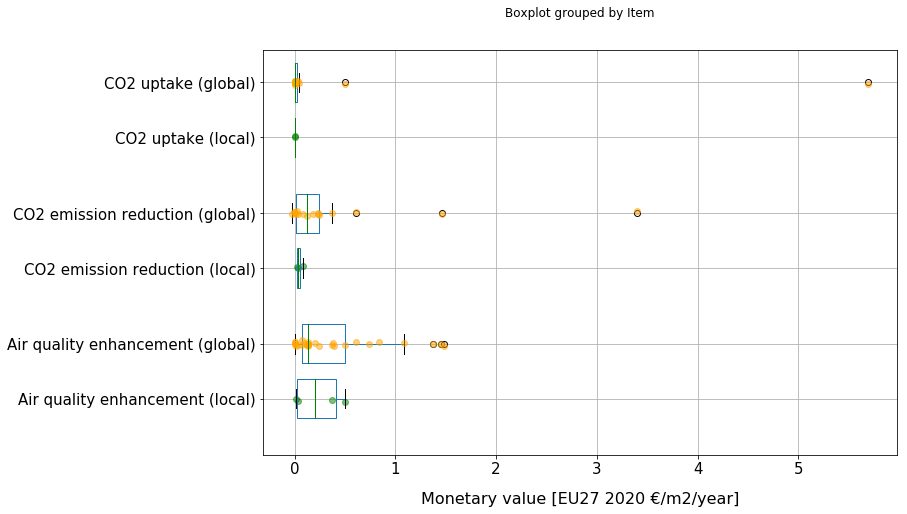

In [90]:
gl_air_quality = global_benefits[(global_benefits["Item"]=="Air quality enhancement") |
                                  (global_benefits["Item"]=="CO2 emission reduction") |
                                  (global_benefits["Item"]=="CO2 uptake") ]
loc_air_quality = local_benefits[(local_benefits["Item"]=="Air quality enhancement") |
                                  (local_benefits["Item"]=="CO2 emission reduction") |
                                  (local_benefits["Item"]=="CO2 uptake") ]



box_gl = gl_air_quality.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                           figsize=(11,7.5), 
                           fontsize=15, 
                           showfliers=True,
                           vert=False,
                           widths = 0.3,
                           positions=[1.35, 2.35, 3.35],
                           return_type= "both",
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_air_quality["Item"].unique()) ):
    x = gl_air_quality["Adjusted Monetary value [EU27 2020 €/m2]"][gl_air_quality["Item"]==item]
    
    # set the plot's position
    n += 0.35
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+1, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)

    
# Add local analysis boxplot and datapoints
for n,item in enumerate( np.sort(loc_air_quality["Item"].unique()) ):  #There is only the aesthetics increase
    x = loc_air_quality["Adjusted Monetary value [EU27 2020 €/m2]"][loc_air_quality["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+.93, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    box_loc = plt.boxplot(x, positions = [n+.93], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.3,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
    
plt.yticks([0.93, 1.35, 1.93, 2.35, 2.93, 3.35], 
           ["Air quality enhancement (local)",
           "Air quality enhancement (global)",
           "CO2 emission reduction (local)",
           "CO2 emission reduction (global)",
           "CO2 uptake (local)",
           "CO2 uptake (global)"],
           fontsize=15)        


plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=16, labelpad=15)
plt.ylim(0.5,3.6);
plt.title('')
plt.savefig("Figures/Air quality",dpi=300, bbox_inches = "tight")


# whiskers' values
print("global boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_gl[0].lines["whiskers"]])
print("local boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_loc["whiskers"]])

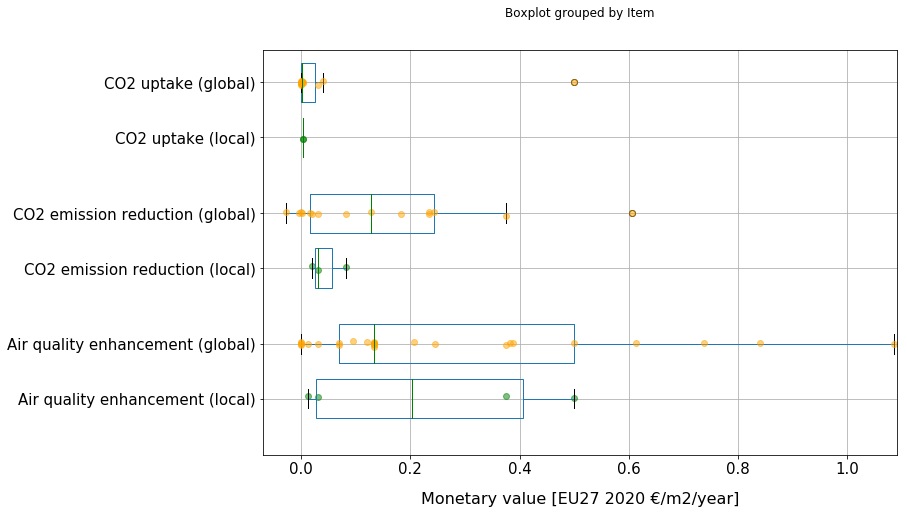

In [16]:
#Zoom of the previous figure

gl_air_quality = global_benefits[(global_benefits["Item"]=="Air quality enhancement") |
                                  (global_benefits["Item"]=="CO2 emission reduction") |
                                  (global_benefits["Item"]=="CO2 uptake") ]
loc_air_quality = local_benefits[(local_benefits["Item"]=="Air quality enhancement") |
                                  (local_benefits["Item"]=="CO2 emission reduction") |
                                  (local_benefits["Item"]=="CO2 uptake") ]



gl_air_quality.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                           figsize=(11,7.5), 
                           fontsize=15, 
                           showfliers=True,
                           vert=False,
                           widths = 0.3,
                           positions=[1.35, 2.35, 3.35],
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_air_quality["Item"].unique()) ):
    x = gl_air_quality["Adjusted Monetary value [EU27 2020 €/m2]"][gl_air_quality["Item"]==item]
    
    # set the plot's position
    n += 0.35
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+1, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)

    
# Add local analysis boxplot and datapoints
for n,item in enumerate( np.sort(loc_air_quality["Item"].unique()) ): 
    x = loc_air_quality["Adjusted Monetary value [EU27 2020 €/m2]"][loc_air_quality["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+.93, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    plt.boxplot(x, positions = [n+.93], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.3,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
    
plt.yticks([0.93, 1.35, 1.93, 2.35, 2.93, 3.35], 
           ["Air quality enhancement (local)",
           "Air quality enhancement (global)",
           "CO2 emission reduction (local)",
           "CO2 emission reduction (global)",
           "CO2 uptake (local)",
           "CO2 uptake (global)"],
           fontsize=15)        


plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=16, labelpad=15)
plt.title('')
plt.xlim(-.07,1.09);
plt.ylim(0.5,3.6);
plt.savefig("Figures/Air quality - zoom",dpi=300, bbox_inches = "tight")


## 3.2 Sound insulation

boxplots' whiskers:  [array([0.28864993, 0.27795919]), array([0.38862264, 0.38862264]), array([1.33620382, 0.27795919]), array([4.91117082, 4.91117082])]


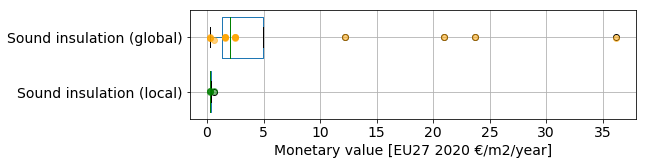

In [93]:
gl_sound = global_benefits[(global_benefits["Item"]=="Sound insulation")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_sound = local_benefits[local_benefits["Item"]=="Sound insulation"]["Adjusted Monetary value [EU27 2020 €/m2]"]

sound_df = pd.DataFrame({'Sound insulation (local)': loc_sound, 'Sound insulation (global)': gl_sound})

_, box = sound_df.boxplot(figsize=(8,2), 
                 fontsize=14, 
                 showfliers=True,
                 rot=0,
                 vert=False,
                 widths = 0.75,
                 return_type="both",
                 color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_sound))
y_local = np.random.normal(1, 0.01, size=len(loc_sound))

#plot the datapoints
plt.plot(gl_sound, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_sound, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14)
plt.title('', fontsize=15)
plt.savefig("Figures/Sound",dpi=300, bbox_inches = "tight")

print("boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box["whiskers"]])

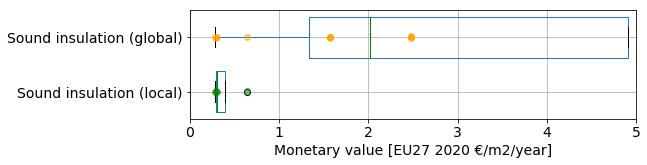

In [35]:
gl_sound = global_benefits[(global_benefits["Item"]=="Sound insulation")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_sound = local_benefits[local_benefits["Item"]=="Sound insulation"]["Adjusted Monetary value [EU27 2020 €/m2]"]

sound_df = pd.DataFrame({'Sound insulation (local)': loc_sound, 'Sound insulation (global)': gl_sound})

sound_df.boxplot(figsize=(8,2), 
                 fontsize=14, 
                 showfliers=True,
                 rot=0,
                 vert=False,
                 widths = 0.75,
                 color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_sound))
y_local = np.random.normal(1, 0.01, size=len(loc_sound))

#plot the datapoints
plt.plot(gl_sound, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_sound, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14)
plt.title('', fontsize=15)
plt.xlim(0,5)

plt.savefig("Figures/Sound - zoom",dpi=300, bbox_inches = "tight")

boxplots' whiskers:  [array([0.28864993, 0.27795919]), array([0.38862264, 0.38862264]), array([0.55293225, 0.27795919]), array([2.47646367, 2.47646367])]


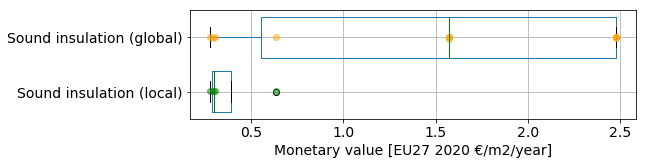

In [95]:
# Exclude case-studies' results that applied hedonic pricing to all floors instead of the highest (Almeida et al.) and 
# non least-cost options using the replacement cost method (Madyìhdiyar et al.). There are the monetary values higher than 10 €/m2 as
# it can be seen in the csv file.

gl_sound = global_benefits[(global_benefits["Item"]=="Sound insulation") &
               (global_benefits["Adjusted Monetary value [EU27 2020 €/m2]"] < 10)]["Adjusted Monetary value [EU27 2020 €/m2]"] 

loc_sound = local_benefits[local_benefits["Item"]=="Sound insulation"]["Adjusted Monetary value [EU27 2020 €/m2]"]

sound_df = pd.DataFrame({'Sound insulation (local)': loc_sound, 'Sound insulation (global)': gl_sound})

_, box = sound_df.boxplot(figsize=(8,2), 
                 fontsize=14, 
                 showfliers=True,
                 rot=0,
                 vert=False,
                 widths = 0.75,
                 return_type="both",
                 color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_sound))
y_local = np.random.normal(1, 0.01, size=len(loc_sound))

#plot the datapoints
plt.plot(gl_sound, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_sound, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14)
plt.title('', fontsize=15)
plt.savefig("Figures/Sound - correction",dpi=300, bbox_inches = "tight")

print("boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box["whiskers"]])

## 3.3 Aesthetics increase

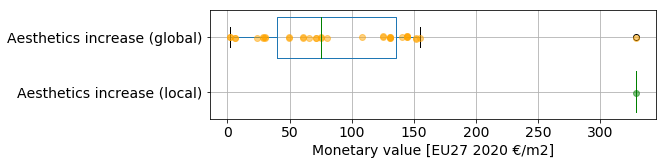

In [31]:
# Plot the Aesthetics increase benefit separately, since it has a different unit of measure

gl_aesthetics = global_benefits[(global_benefits["Item"]=="Aesthetics increase")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_aesthetics = local_benefits[local_benefits["Item"]=="Aesthetics increase"]["Adjusted Monetary value [EU27 2020 €/m2]"]

aesthetics_df = pd.DataFrame({'Aesthetics increase (local)': loc_aesthetics, 'Aesthetics increase (global)': gl_aesthetics})

f = aesthetics_df.boxplot(figsize=(8,2), 
                          fontsize=14, 
                          showfliers=True,
                          rot=0,
                          vert=False,
                          widths = 0.75,
                          color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_aesthetics))
y_local = np.random.normal(1, 0.01, size=len(loc_aesthetics))

#plot the datapoints
plt.plot(gl_aesthetics, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_aesthetics, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2]', fontsize=14)
plt.title('', fontsize=15)

plt.savefig("Figures/Aesthetics",dpi=300, bbox_inches = "tight")

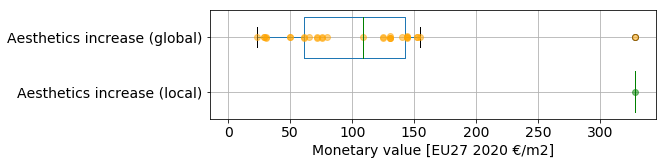

In [30]:
# Plot the Aesthetics increase without Bianchini and Hewage's results

gl_aesthetics = global_benefits[(global_benefits["Item"]=="Aesthetics increase") & 
                (global_benefits["Adjusted Monetary value [EU27 2020 €/m2]"]>7)]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_aesthetics = local_benefits[local_benefits["Item"]=="Aesthetics increase"]["Adjusted Monetary value [EU27 2020 €/m2]"]

aesthetics_df = pd.DataFrame({'Aesthetics increase (local)': loc_aesthetics, 'Aesthetics increase (global)': gl_aesthetics})

f = aesthetics_df.boxplot(figsize=(8,2), 
                          fontsize=14, 
                          showfliers=True,
                          rot=0,
                          vert=False,
                          widths = 0.75,
                          color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_aesthetics))
y_local = np.random.normal(1, 0.01, size=len(loc_aesthetics))

#plot the datapoints
plt.plot(gl_aesthetics, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_aesthetics, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2]', fontsize=14)
plt.title('', fontsize=15)
plt.xlim(-15,34)

plt.savefig("Figures/Aesthetics - correction",dpi=300, bbox_inches = "tight")

## 3.4 Stormwater management

[array([0.32365048, 0.09672573]),
 array([0.89378491, 1.46894293]),
 array([0.02786823, 0.0022549 ]),
 array([0.89196303, 1.46894293])]

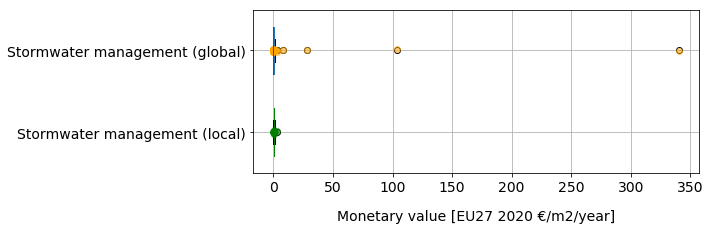

In [80]:
gl_stormwater = global_benefits[(global_benefits["Item"]=="Stormwater management")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_stormwater = local_benefits[(local_benefits["Item"]=="Stormwater management")]["Adjusted Monetary value [EU27 2020 €/m2]"]

stormwater_df = pd.DataFrame({'Stormwater management (local)': loc_stormwater, 'Stormwater management (global)': gl_stormwater})

_, box = stormwater_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               return_type="both",
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_stormwater))
y_local = np.random.normal(1, 0.01, size=len(loc_stormwater))

#plot the datapoints
plt.plot(gl_stormwater, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_stormwater, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

    
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Stormwater",dpi=300, bbox_inches = "tight")

# whiskers' values (the first numbers are the local boxplot's values)
[whiskers.get_xdata() for whiskers in box["whiskers"]]

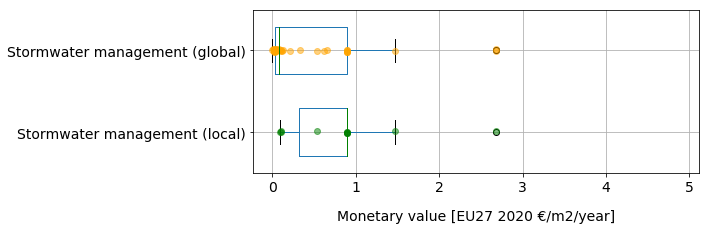

In [98]:
gl_stormwater = global_benefits[(global_benefits["Item"]=="Stormwater management")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_stormwater = local_benefits[(local_benefits["Item"]=="Stormwater management")]["Adjusted Monetary value [EU27 2020 €/m2]"]

stormwater_df = pd.DataFrame({'Stormwater management (local)': loc_stormwater, 'Stormwater management (global)': gl_stormwater})

box = stormwater_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_stormwater))
y_local = np.random.normal(1, 0.01, size=len(loc_stormwater))

#plot the datapoints
plt.plot(gl_stormwater, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_stormwater, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlim(-.23,5.12)
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Stormwater - zoom",dpi=300, bbox_inches = "tight")

## 3.6 Energy consumption reduction

[array([0.28892377, 0.07898974]),
 array([0.46129663, 0.52114451]),
 array([ 0.28892377, -0.38447616]),
 array([1.7872481, 3.8655441])]

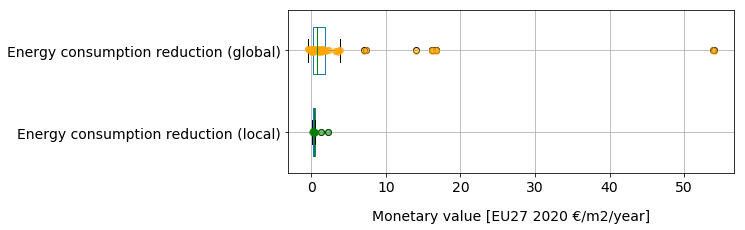

In [128]:
gl_energy_red = global_benefits[(global_benefits["Item"]=="Energy consumption reduction (heating and cooling)")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_energy_red = local_benefits[(local_benefits["Item"]=="Energy consumption reduction (heating and cooling)")]["Adjusted Monetary value [EU27 2020 €/m2]"]

energy_red_df = pd.DataFrame({'Energy consumption reduction (local)': loc_energy_red, 'Energy consumption reduction (global)': gl_energy_red})

_, box = energy_red_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               return_type="both",
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_energy_red))
y_local = np.random.normal(1, 0.01, size=len(loc_energy_red))

#plot the datapoints
plt.plot(gl_energy_red, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_energy_red, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

    
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Energy consumption reduction",dpi=300, bbox_inches = "tight")

# whiskers' values (the first numbers are the local boxplot's values)
[whiskers.get_xdata() for whiskers in box["whiskers"]]

[array([0.28892377, 0.07898974]),
 array([0.46129663, 0.52114451]),
 array([ 0.28892377, -0.38447616]),
 array([1.7872481, 3.8655441])]

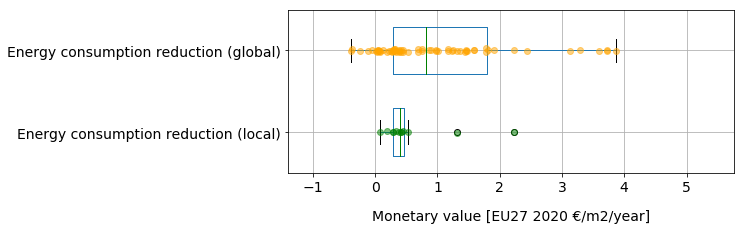

In [150]:
# Zoom of the previous figure

gl_energy_red = global_benefits[(global_benefits["Item"]=="Energy consumption reduction (heating and cooling)")]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_energy_red = local_benefits[(local_benefits["Item"]=="Energy consumption reduction (heating and cooling)")]["Adjusted Monetary value [EU27 2020 €/m2]"]

energy_red_df = pd.DataFrame({'Energy consumption reduction (local)': loc_energy_red, 'Energy consumption reduction (global)': gl_energy_red})

_, box = energy_red_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               return_type="both",
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_energy_red))
y_local = np.random.normal(1, 0.01, size=len(loc_energy_red))

#plot the datapoints
plt.plot(gl_energy_red, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_energy_red, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlim(-1.4,5.77)
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Energy consumption reduction - zoom",dpi=300, bbox_inches = "tight")

# whiskers' values (the first numbers are the local boxplot's values)
[whiskers.get_xdata() for whiskers in box["whiskers"]]

[array([0.28892377, 0.07898974]),
 array([0.46129663, 0.52114451]),
 array([ 0.28187111, -0.38447616]),
 array([1.72601856, 3.8655441 ])]

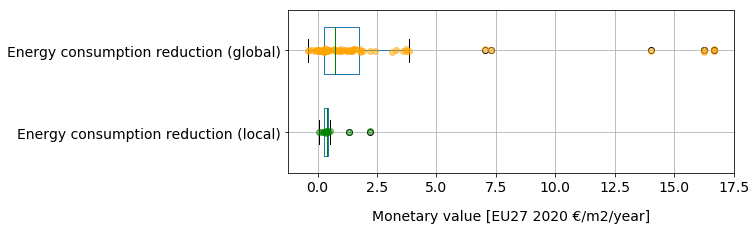

In [149]:
# Exclude values by William et al.

gl_energy_red = global_benefits[(global_benefits["Item"]=="Energy consumption reduction (heating and cooling)") &
                                (global_benefits["Adjusted Monetary value [EU27 2020 €/m2]"] < 50)]["Adjusted Monetary value [EU27 2020 €/m2]"]
loc_energy_red = local_benefits[(local_benefits["Item"]=="Energy consumption reduction (heating and cooling)")]["Adjusted Monetary value [EU27 2020 €/m2]"]

energy_red_df = pd.DataFrame({'Energy consumption reduction (local)': loc_energy_red, 'Energy consumption reduction (global)': gl_energy_red})

_, box = energy_red_df.boxplot(figsize=(8,3), 
                               fontsize=14, 
                               showfliers=True,
                               rot=0,
                               vert=False,
                               widths = 0.58,
                               return_type="both",
                               color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add datapoints

# Add some random "jitter" to the y-axis
y_global = np.random.normal(2, 0.01, size=len(gl_energy_red))
y_local = np.random.normal(1, 0.01, size=len(loc_energy_red))

#plot the datapoints
plt.plot(gl_energy_red, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
plt.plot(loc_energy_red, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);

plt.savefig("Figures/Energy consumption reduction - correction",dpi=300, bbox_inches = "tight")

# whiskers' values (the first numbers are the local boxplot's values)
[whiskers.get_xdata() for whiskers in box["whiskers"]]

## 3.5 Other benefits

global boxplots' whiskers:  [array([9.91527617, 2.79789135]), array([15.32994777, 18.84615094]), array([0.98865729, 0.        ]), array([3.31562514, 5.47801262]), array([0., 0.]), array([2.54408569, 3.26499858])]
local boxplots' whiskers:  [array([0., 0.]), array([0., 0.])]


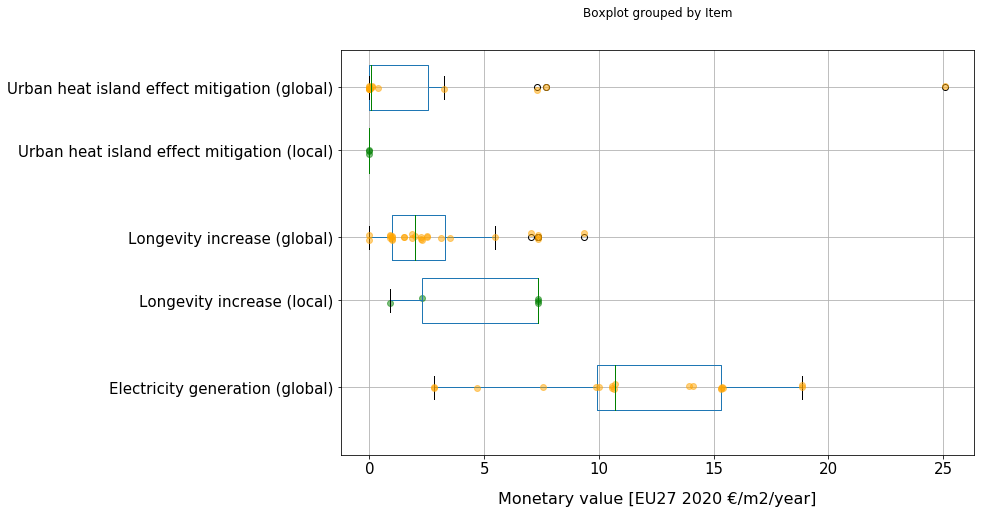

In [184]:
gl_benefits_overview = global_benefits[(global_benefits["Item"]=="Urban heat island effect mitigation") |
                                       (global_benefits["Item"]=="Longevity increase") |
                                       (global_benefits["Item"]=="Electricity generation")].drop([2,3,4,38,44,50,666,665,664,284,285], axis=0)
                                       
loc_benefits_overview = local_benefits[(local_benefits["Item"]=="Urban heat island effect mitigation") |
                                       (local_benefits["Item"]=="Longevity increase") |
                                       (local_benefits["Item"]=="Electricity generation")]



box_gl = gl_benefits_overview.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                           figsize=(11,7.5), 
                           fontsize=15, 
                           showfliers=True,
                           vert=False,
                           widths = 0.3,
                           positions=[1.35, 2.35, 3.35],
                           return_type= "both",
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_benefits_overview["Item"].unique()) ):
    x = gl_benefits_overview["Adjusted Monetary value [EU27 2020 €/m2]"][gl_benefits_overview["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+1.35, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)

    
# Add local analysis boxplot and datapoints
for m,item in enumerate( np.sort(loc_benefits_overview["Item"].unique()) ):
    x = loc_benefits_overview["Adjusted Monetary value [EU27 2020 €/m2]"][loc_benefits_overview["Item"]==item]
    
    m+= 1
    # Add some random "jitter" to the y-axis
    y = np.random.normal(m+.93, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    box_loc = plt.boxplot(x, positions = [m+.93], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.3,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
    
plt.yticks([1.35, 1.93, 2.35, 2.93, 3.35], 
           ["Electricity generation (global)",
           "Longevity increase (local)",
           "Longevity increase (global)",
           "Urban heat island effect mitigation (local)",
           "Urban heat island effect mitigation (global)"],
           fontsize=15)        


plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=16, labelpad=15)
plt.ylim(0.9,3.6);
plt.title('')
plt.savefig("Figures/Other benefits 1",dpi=300, bbox_inches = "tight")


# whiskers' values
print("global boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_gl[0].lines["whiskers"]])
print("local boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_loc["whiskers"]])

global boxplots' whiskers:  [array([0.00346801, 0.        ]), array([0.67175204, 0.67175204]), array([0.03109963, 0.        ]), array([0.09951882, 0.11195867]), array([0.00124399, 0.00124399]), array([0.14723783, 0.32377664])]
local boxplots' whiskers:  [array([0.30086792, 0.29323168]), array([0.3161404 , 0.32377664])]


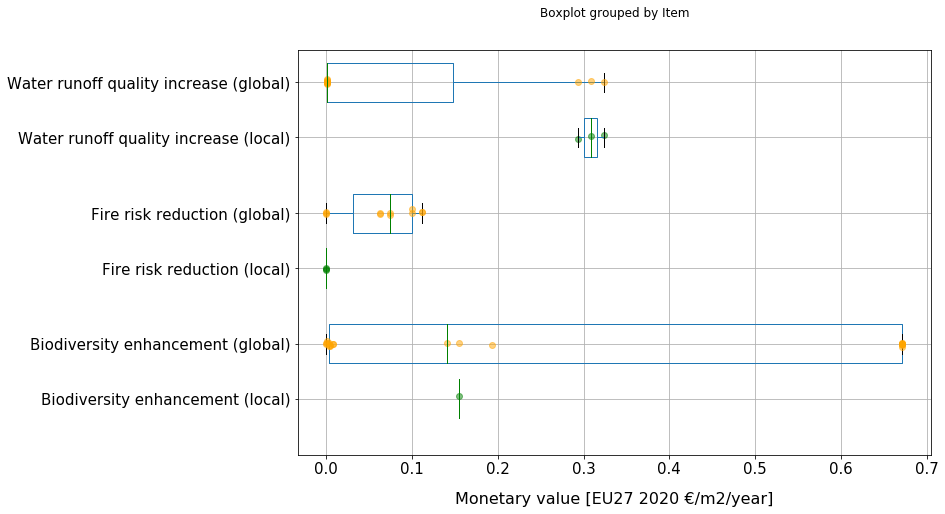

In [185]:
#Overview of distributions of the yearly benefits

gl_benefits_overview2 = global_benefits[(global_benefits["Item"]=="Water runoff quality increase") | 
                                       (global_benefits["Item"]=="Biodiversity enhancement") |
                                       (global_benefits["Item"]=="Fire risk reduction")]
                                       
loc_benefits_overview2 = local_benefits[(local_benefits["Item"]=="Water runoff quality increase") | 
                                       (local_benefits["Item"]=="Biodiversity enhancement") |
                                       (local_benefits["Item"]=="Fire risk reduction")]



box_gl = gl_benefits_overview2.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                           figsize=(11,7.5), 
                           fontsize=15, 
                           showfliers=True,
                           vert=False,
                           widths = 0.3,
                           positions=[1.35, 2.35, 3.35],
                           return_type= "both",
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))

# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_benefits_overview2["Item"].unique()) ):
    x = gl_benefits_overview2["Adjusted Monetary value [EU27 2020 €/m2]"][gl_benefits_overview2["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(n+1.35, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)

    
# Add local analysis boxplot and datapoints
for m,item in enumerate( np.sort(loc_benefits_overview2["Item"].unique()) ):
    x = loc_benefits_overview2["Adjusted Monetary value [EU27 2020 €/m2]"][loc_benefits_overview2["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(m+.93, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    box_loc = plt.boxplot(x, positions = [m+.93], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.3,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
    
plt.yticks([0.93, 1.35, 1.93, 2.35, 2.93, 3.35], 
           ["Biodiversity enhancement (local)",
           "Biodiversity enhancement (global)",
           "Fire risk reduction (local)",
           "Fire risk reduction (global)",
           "Water runoff quality increase (local)",
           "Water runoff quality increase (global)"],
           fontsize=15)        


plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=16, labelpad=15)
plt.ylim(0.5,3.6);
plt.title('')
plt.savefig("Figures/Other benefits 2",dpi=300, bbox_inches = "tight")


# whiskers' values
print("global boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_gl[0].lines["whiskers"]])
print("local boxplots' whiskers: ",[whiskers.get_xdata() for whiskers in box_loc["whiskers"]])

## Additional code

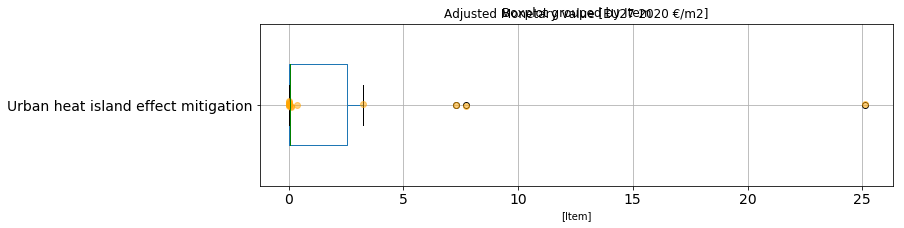

In [126]:
global_benefits[(global_benefits["Item"]=="Urban heat island effect mitigation")].drop([2,3,4,38,44,50,666,665,664,284,285], axis=0).boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                            figsize=(11,3), 
                            fontsize=14, 
                            showfliers=True,
                            rot = 0,
                            vert=False,
                            widths = 0.5,
                            color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))
# Add datapoints
gl_heat = global_benefits[(global_benefits["Item"]=="Urban heat island effect mitigation")].drop([2,3,4,38,44,50,666,665,664,284,285], axis=0)["Adjusted Monetary value [EU27 2020 €/m2]"]
# Add some random "jitter" to the y-axis
y_global = np.random.normal(1, 0.01, size=len(gl_heat))
# y_local = np.random.normal(1, 0.01, size=len(loc_stormwater))

#plot the datapoints
plt.plot(gl_heat, y_global, 'orange', marker="o", linestyle="None", alpha=0.5)
# plt.plot(loc_stormwater, y_local, 'green', marker="o", linestyle="None", alpha=0.5)

# plt.xlim(-0.9, 1.9)


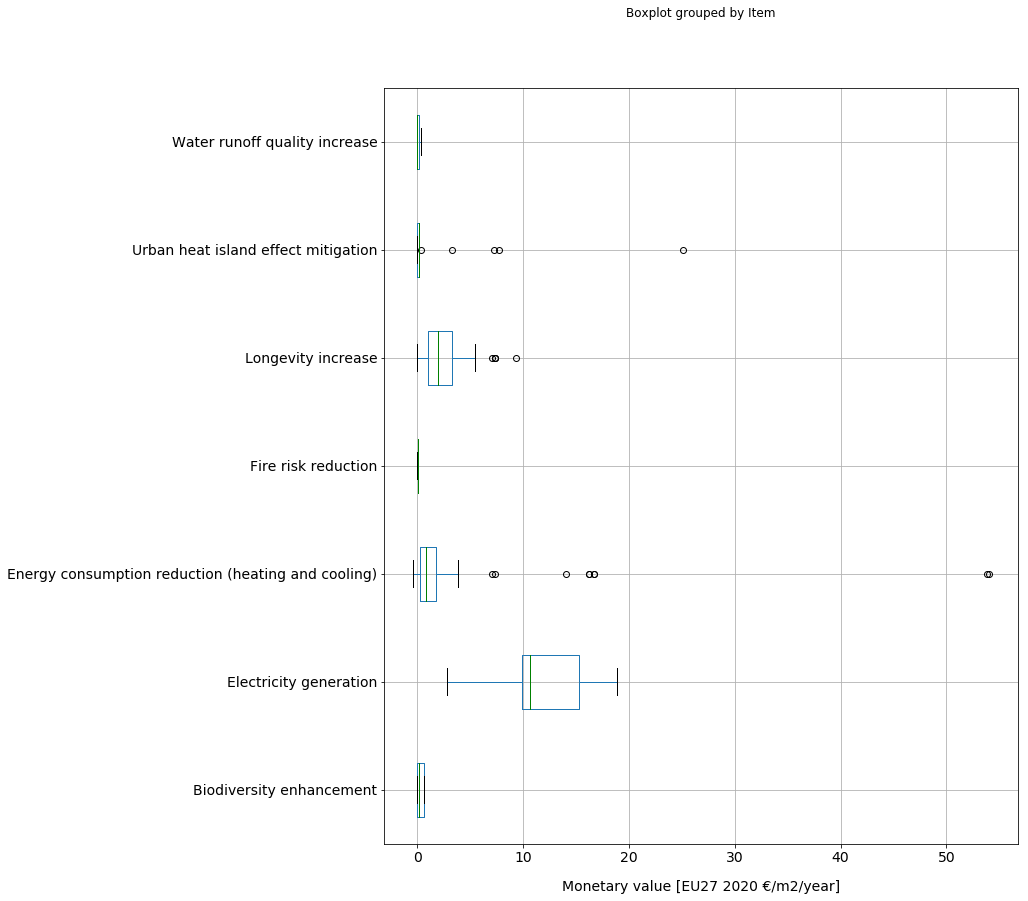

In [103]:
#Overview of distributions of the yearly benefits

gl_benefits_overview = global_benefits[(global_benefits["Item"]=="Urban heat island effect mitigation") |
                                       (global_benefits["Item"]=="Water runoff quality increase") | 
                                       (global_benefits["Item"]=="Biodiversity enhancement") |
                                       (global_benefits["Item"]=="Energy consumption reduction (heating and cooling)") |
                                       (global_benefits["Item"]=="Longevity increase") |
                                       (global_benefits["Item"]=="Fire risk reduction") |
                                       (global_benefits["Item"]=="Electricity generation")]
                                       
loc_benefits_overview = local_benefits[(local_benefits["Item"]=="Urban heat island effect mitigation") |
                                       (local_benefits["Item"]=="Water runoff quality increase") | 
                                       (local_benefits["Item"]=="Biodiversity enhancement") |
                                       (local_benefits["Item"]=="Energy consumption reduction (heating and cooling)") |
                                       (local_benefits["Item"]=="Longevity increase") |
                                       (local_benefits["Item"]=="Fire risk reduction") |
                                       (local_benefits["Item"]=="Electricity generation")]

gl_boxplot_positions = range(1,8,1)
gl_benefits_overview.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                            figsize=(11,14), 
                            fontsize=14, 
                            showfliers=True,
                            rot = 0,
                            vert=False,
                            widths = 0.5,
                            positions = gl_boxplot_positions,
                            color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))
                           
plt.xlabel('Monetary value [EU27 2020 €/m2/year]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);



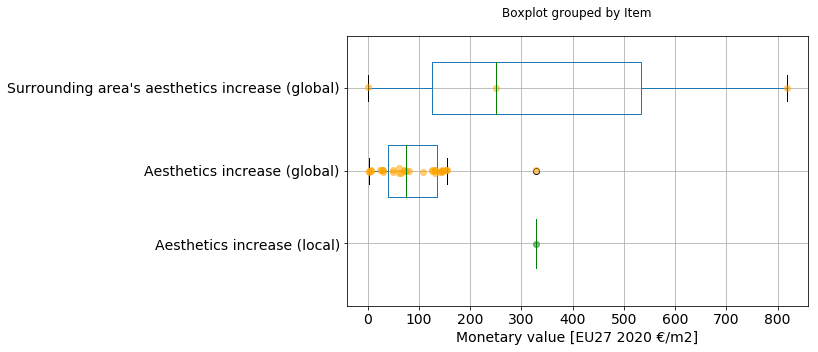

In [33]:
#Overview of distributions of the one-time benefits

gl_aesthetics = global_benefits[(global_benefits["Item"]=="Local area's aesthetics increase") |
                                    (global_benefits["Item"]=="Aesthetics increase")]
loc_aesthetics = local_benefits[(local_benefits["Item"]=="Local area's aesthetics increase") |
                                    (local_benefits["Item"]=="Aesthetics increase")]

# Add global analysis' boxplots
gl_aesthetics.boxplot(column="Adjusted Monetary value [EU27 2020 €/m2]", by=["Item"], 
                            figsize=(8,5), 
                            fontsize=14, 
                            showfliers=True,
                            rot = 0,
                            vert=False,
                            widths = 0.5,
                            positions=[1.2, 2],
                            color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))


# Add global analysis' datapoints
for n,item in enumerate( np.sort(gl_aesthetics["Item"].unique()) ):
    x = gl_aesthetics["Adjusted Monetary value [EU27 2020 €/m2]"][gl_aesthetics["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    if n == 0: #in the case of the "Aesthetics increase (global)" increase the height
        n = 0.2
    
    y = np.random.normal(n+1, 0.01, size=len(x))
    plt.plot(x, y, 'orange', marker="o", linestyle="None", alpha=0.5)

    
    
# Add local analysis boxplot and datapoints

for n,item in enumerate( np.sort(loc_aesthetics["Item"].unique()) ):  #There is only the aesthetics increase
    x = loc_aesthetics["Adjusted Monetary value [EU27 2020 €/m2]"][loc_aesthetics["Item"]==item]
    
    # Add some random "jitter" to the y-axis
    y = np.random.normal(0.5, 0.02, size=len(x))
    
    plt.plot(x, y, 'green', marker="o", linestyle="None", alpha=0.5)
    plt.boxplot(x, positions = [0.5], vert=False, manage_xticks=False, patch_artist=True,
                widths=0.47,
                boxprops=dict(facecolor="None", color='#1f77b4'),
                capprops=dict(color="black"),
                whiskerprops=dict(color='#1f77b4'),
                flierprops=dict(color="white", markeredgecolor="black"),
                medianprops=dict(color="g"))
    
    
plt.yticks([0.5, 1.2, 2], ["Aesthetics increase (local)",
                           "Aesthetics increase (global)",
                           "Surrounding area's aesthetics increase (global)"])    
plt.xlabel('Monetary value [EU27 2020 €/m2]', fontsize=14, labelpad=15)
plt.title('', fontsize=15);
plt.ylim(-.1,2.5);

In [14]:
# When outliers are excluded from the analysis the distribution of benefit values is provided by the following figure.
# The number of values for each item (i.e., cost or benefit) is provided in the summary_benefits table calculated at the top
# of this document

benefits_data_without_area_aesth = benefits_data[(benefits_data["Item"]!="Local area's aesthetics increase") & 
                                                 (benefits_data["Item"]!="Aesthetics increase")
                                                ]

benefits_data_without_area_aesth.boxplot(column="Adjusted Monetary value [EU27 2019 €/m2]", by=["Item"], 
                                         figsize=(11,6), 
                                         fontsize=14, 
                                         showfliers=False,
                                         rot = 90,
                                         color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'))
                           
plt.ylabel('Adjusted Monetary value [EU27 2019 €/m2/year]', fontsize=14)
plt.title('', fontsize=15);

NameError: name 'benefits_data' is not defined

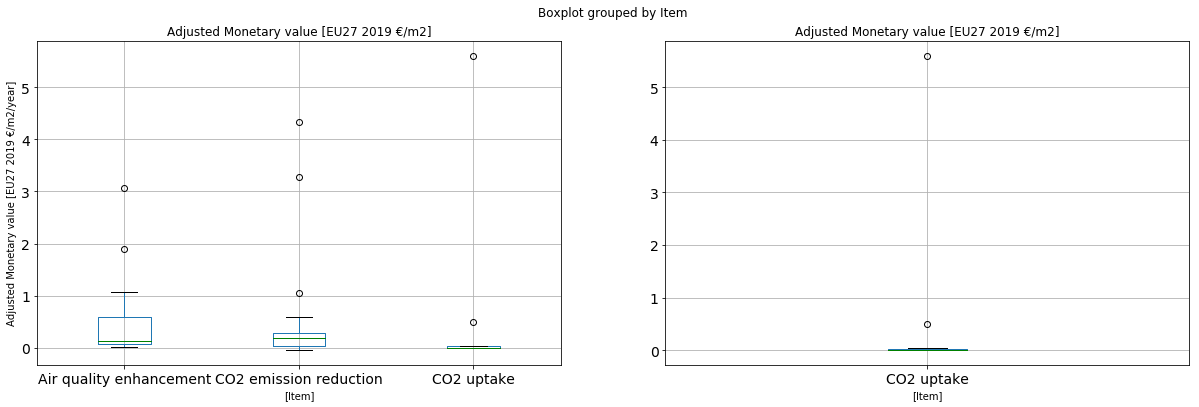

In [131]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6), sharey = False) # create 1x2 array of subplots
plt.title('', fontsize=15)
# plt.savefig("Figures/Air quality overlaps",dpi=300, bbox_inches = "tight")


air_quality_issues = cleaned_data[(cleaned_data["Item"]=="Air quality enhancement") |
                                  (cleaned_data["Item"]=="CO2 emission reduction") |
                                  (cleaned_data["Item"]=="CO2 uptake") ]
CO2_uptake = cleaned_data[cleaned_data["Item"]=="CO2 uptake"]


air_quality_issues.boxplot(column="Adjusted Monetary value [EU27 2019 €/m2]", by=["Item"], 
                           figsize=(15,6), 
                           fontsize=14, 
                           showfliers=True,
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'),
                           ax = axes[0])
axes[0].set(ylabel= "Adjusted Monetary value [EU27 2019 €/m2/year]")
                           


CO2_uptake.boxplot(column="Adjusted Monetary value [EU27 2019 €/m2]", by=["Item"], 
                           figsize=(3,6), 
                           fontsize=14, 
                           showfliers=True,
                           color=dict(boxes='#1f77b4', whiskers='#1f77b4', medians='g', caps='black'),
                           ax = axes[1])

## 4. Time horizon of CBAs

In [86]:
# Load global analysis data
raw_CBA_data = pd.read_csv("Data/CBA parameters.csv")
raw_CBA_data

,Private discount rate (min) [%],Private discount rate (max) [%],Social discount rate (min) [%],Social discount rate (max) [%],Non-specified type of iscount rate (min) [%],Non-specified type of discount rate (max) [%],Time horizon [years],Authors,Year,Author and year,Study,Notes,Local analysis,Unnamed: 13
0,4.00,4.00,4.00,4.00,NaN,NaN,40,Carter & Keeler,2008,Carter & Keeler (2008),Life-cycle cost-benefit analysis of extensive ...,commercial buildings: Although the whole area ...,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,20,Ascione et al.,2013,Ascione et al. (2013),Green roofs in European climates. Are effectiv...,€ values concerned with the UK were converted ...,x,yes
2,9.00,9.00,4.00,4.00,NaN,NaN,50,Claus & Rousseau,2012,Claus & Rousseau (2012),Public versus private incentives to invest in ...,Maintenance cost: includes water sampling cost...,x,NaN
3,8.00,15.00,NaN,NaN,NaN,NaN,50,Mahdiyar et al.,2016,Mahdiyar et al. (2016),Probabilistic private cost-benefit analysis fo...,$ values were converted to MYR currency with t...,NaN,yes
4,NaN,NaN,2.00,8.00,NaN,NaN,55,Bianchini & Hewage,2012,Bianchini & Hewage (2012),Probabilistic social cost-benefit analysis for...,NaN,x,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,40,Bianchini & Hewage,2012,Bianchini & Hewage (2012),Probabilistic social cost-benefit analysis for...,NaN,NaN,yes
6,3.00,3.00,NaN,NaN,NaN,NaN,25,McRae,2016,McRae (2016),Case study: A conservative approach to green r...,NaN,NaN,yes
7,NaN,NaN,NaN,NaN,5.0,5.0,40,Clark et al.,2008,Clark et al. (2008),Green roof valuation: a probabilisitc economic...,Extensive roof depth: 5-15 cm,NaN,yes
8,3.50,3.50,NaN,NaN,NaN,NaN,50,Perini & Rosasco,2016,Perini & Rosasco (2016),Is greening the building envelope economically...,NaN,NaN,yes
9,NaN,NaN,NaN,NaN,NaN,NaN,10,Gwak et al.,2017,Gwak et al. (2017),Optimal location selection for the installatio...,$ values were converted to KRW currency with t...,NaN,yes


In [87]:
# Select local analysis data
local_CBA_data = raw_CBA_data[raw_CBA_data["Local analysis"]=="x"]
local_CBA_data

,Private discount rate (min) [%],Private discount rate (max) [%],Social discount rate (min) [%],Social discount rate (max) [%],Non-specified type of iscount rate (min) [%],Non-specified type of discount rate (max) [%],Time horizon [years],Authors,Year,Author and year,Study,Notes,Local analysis,Unnamed: 13
1,NaN,NaN,NaN,NaN,NaN,NaN,20,Ascione et al.,2013,Ascione et al. (2013),Green roofs in European climates. Are effectiv...,€ values concerned with the UK were converted ...,x,yes
2,9.0,9.0,4.0,4.0,NaN,NaN,50,Claus & Rousseau,2012,Claus & Rousseau (2012),Public versus private incentives to invest in ...,Maintenance cost: includes water sampling cost...,x,NaN
4,NaN,NaN,2.0,8.0,NaN,NaN,55,Bianchini & Hewage,2012,Bianchini & Hewage (2012),Probabilistic social cost-benefit analysis for...,NaN,x,NaN
11,NaN,NaN,4.0,4.0,NaN,NaN,50,Machac et al.,2016,Machac et al. (2016),Green and Blue Infrastructure: An Opportunity ...,NaN,x,NaN
17,3.0,3.0,3.0,3.0,NaN,NaN,50,Johnson & Geisendorf,2019,Johnson & Geisendorf (2019),Are Neighborhood-level SUDS Worth it? An asses...,Degree days for cooling were considered to be ...,x,NaN


C:\Users\Timme\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


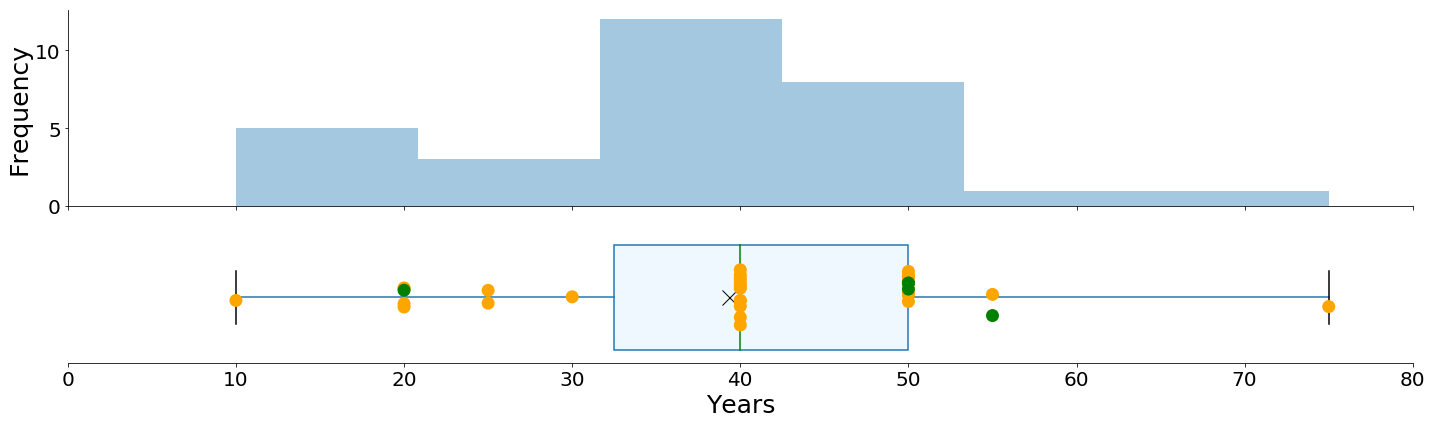

In [144]:
# Plot the distribution of CBAs' time_horizon 

# prepare data for global and local analyses' plots
global_data = raw_CBA_data[["Time horizon [years]"]]
local_data = raw_CBA_data[raw_CBA_data["Local analysis"]=="x"]["Time horizon [years]"]

# generate boxplot with distribution of values (strip plot) for the global and, in a different color, for the local 
# analysis, additionally plot the and histogram of values for the global analysis on top of it.
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, figsize=(20,6),
                                    gridspec_kw={"height_ratios": (0.60, 0.4)})

sns.distplot(global_data, ax=ax_hist, bins= 6, kde= False)
sns.stripplot(global_data, jitter=0.23, ax=ax_box, size=13, color="orange")
sns.stripplot(local_data, jitter=0.2, ax=ax_box, size=13, color="green")

props = {
    'boxprops':{'facecolor':'aliceblue', 'edgecolor':'#1f77b4'},
    'medianprops':{'color':'g'},
    'whiskerprops':{'color':'#1f77b4'},
    'capprops':{'color':'black'}}

sns.boxplot(global_data, ax=ax_box,
            showmeans = True,
            meanprops={"marker":"x","markerfacecolor":"black", "markeredgecolor":"black", "markersize":15},
           **props)


ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

ax_box.set_xlim(0,80)
ax_hist.set_xlim(0,80)
ax_box.set_xlabel("Years",fontsize=25)
ax_hist.set_ylabel("Frequency",fontsize=25)
ax_box.tick_params(axis='x', which='major', labelsize=20)
ax_hist.tick_params(axis='x', which='major', labelsize=20)
ax_hist.tick_params(axis='y', which='major', labelsize=20)
f.tight_layout()

# Save the plot
plt.savefig("Figures/CBA time horizons strip_plot",dpi=300, bbox_inches = "tight")

In [78]:
x_global = pd.DataFrame(raw_CBA_data["Time horizon [years]"])
x_global = pd.merge(x_global, pd.Series(np.zeros(len(x_global)), name="local_analysis"), left_index=True, right_index=True)
x_local = pd.DataFrame(raw_CBA_data[raw_CBA_data["Local analysis"]=="x"]["Time horizon [years]"])
x_local = pd.merge(x_local, pd.Series(np.ones(len(x_local)), name="local_analysis"), left_index=True, right_index=True)

x_df = x_global.append(x_local, ignore_index= True)
x_df

,Time horizon [years],local_analysis
0,40,0.0
1,20,0.0
2,50,0.0
3,50,0.0
4,55,0.0
5,40,0.0
6,25,0.0
7,40,0.0
8,50,0.0
9,10,0.0
